<a href="https://colab.research.google.com/github/Shaz-Momin/Diamonds-ML-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Project: Diamonds

Team Members: Ankit Bhattacharyya, Shaz Momin, Rayan Ali, Hussain Murtaza 

In [ ]:
# Standard Headers
import pandas as pd
import sklearn
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter("ignore")

# For reading file from drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/CS 363M/Project/diamonds.csv')
# df = pd.read_csv('diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,'x','y','z'
0,0.23,b'Ideal',b'E',b'SI2',61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,b'Premium',b'E',b'SI1',59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,b'Good',b'E',b'VS1',56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,b'Premium',b'I',b'VS2',62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,b'Good',b'J',b'SI2',63.3,58.0,335.0,4.34,4.35,2.75


# Data Cleaning/Exploration

The dataset documentation mentioned that there were several duplicate entries where the same diamond was measured from different angles. To remove these, we took a look at angle independent attributes (carat, cut, clarity, price, color) for duplicates.

In [ ]:
# Removing duplicates
subset = ['carat','cut','clarity', 'price','color']
df.drop_duplicates(subset, inplace=True)
print(df.shape)

# DATA EXPLORATION - Through various modeling techniques we figured out that we
# get strong positive R2 scores when we split the data into train and test sets but when we
# use the entire dataset and perform the cross-validation with 'cross_val_score', 
# we got a range of negative and low correlative R2 scores.
# This is because the diamonds data is initially presented in sorted
# order. Therefore, when a test set was set aside it contained many diamonds with similar values.
# This caused the trained model to score poorly on testing data because it had not seen
# datapoints like those in the test set before.
# In order to fix this issue and shuffle records around, we are sampling
# the dataframe below so that the data is randomized.
df = df.sample(frac=1)

(39756, 10)


# Feature Engineering

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding on a scale
ordinal_reg = OrdinalEncoder(categories=[['b\'Fair\'','b\'Good\'', 'b\'Ideal\'', 'b\'Premium\'', 'b\'Very Good\''], 
                                ['b\'J\'', 'b\'I\'', 'b\'H\'', 'b\'G\'', 'b\'F\'', 'b\'E\'', 'b\'D\''],
                                ['b\'I1\'','b\'SI2\'', 'b\'SI1\'', 'b\'VS2\'', 'b\'VS1\'', 'b\'VVS2\'', 'b\'VVS1\'', 'b\'IF\'']])

ordinal_class = OrdinalEncoder(categories=[ 
                                ['b\'J\'', 'b\'I\'', 'b\'H\'', 'b\'G\'', 'b\'F\'', 'b\'E\'', 'b\'D\''],
                                ['b\'I1\'','b\'SI2\'', 'b\'SI1\'', 'b\'VS2\'', 'b\'VS1\'', 'b\'VVS2\'', 'b\'VVS1\'', 'b\'IF\'']])

df_reg = df.copy()
df_reg[['cut','color','clarity']] = ordinal_reg.fit_transform(df_reg[['cut','color','clarity']])

df_class = df.copy()
df_class[['color','clarity']] = ordinal_class.fit_transform(df_class[['color','clarity']])

# Data Modeling
We are using 'price' as a class feature where we are trying to figure out how other features like carat, cut, clarity, color, x_fracture, y_fracture, z_fracture, and depth of the diamond can be use to predict the price.
In order to further this idea, we will be implementing supervised learning to predict the price of the diamond and unsupervised learning to classify the cut of the dimaond based on other features.

## Regression Model

First, we start by checking whether any of the individual features correlate very strongly with the label ('price')

In [ ]:
# Shaz
from sklearn.linear_model import LinearRegression

df_reg.corr()['price'] # Price highly correlates with carat (0.911056)
# We also get the x_fracture, y-fracture, and z-fracture of the diamond
# correlating with the price however, in this case, the correlation 
# does not infer causation since these features are available in all
# types of carats that the diamond is available and does not necessarily
# contribute to the price

carat      0.911056
cut        0.041378
color     -0.148372
clarity   -0.096622
depth     -0.008171
table      0.093227
price      1.000000
'x'        0.876477
'y'        0.855609
'z'        0.845367
Name: price, dtype: float64

Since 'carat' feature relates the most, we are performing a simple Linear Regression Model to predict price from carat:



records in training set: x  31804  | y  31804
records in test set: x  7952  | y  7952

Mean Absolute Error (MAE):  1181.2994255889791
	In this context, MAE tells us that we are about $1150 off on average based on the best fit predicted line
Mean Squared Error (MSE):  3074006.8140162444
Root Mean Squared Error (RMSE):  1753.2845787310869
R2 Score:  0.8307001186938031



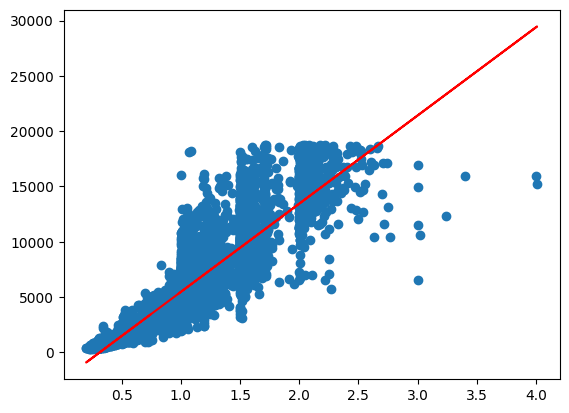

In [ ]:
# predicting price from carat
x = df_reg['carat']
y = df_reg['price']
x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# splitting (train & test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)
print("records in training set: x ", len(x_train), " | y ", len(y_train))
print("records in test set: x ", len(x_test), " | y ", len(y_test), end='\n\n')

# fitting the set
lr = LinearRegression().fit(x_train, y_train)
''' print("slope: ", lr.coef_[0][0])
print("intercept: ", lr.intercept_[0], end='\n\n') '''

# Plotting the best fit line
pred = lr.predict(x_test)
plt.scatter(x_test, y_test)
plt.plot(x_test, pred, color='red')

# Using cross-validation to check R2
''' sampled_data = f_reg.sample(frac=1)
sampled_x = sampled_data['carat'].array.reshape(-1, 1)
sampled_y = sampled_data['price'] '''
r2Arr = cross_val_score(LinearRegression(), x, y)
print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(y_test, pred))
print("\tIn this context, MAE tells us that we are about $1150 off on average based on the best fit predicted line")
print('Mean Squared Error (MSE): ', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE): ', metrics.mean_squared_error(y_test, pred, squared=False))
print('R2 Score: ', metrics.r2_score(y_test, pred), end='\n\n') # Pretty high, model fits the data well

Multiple Linear Regression:

In [ ]:
# Multiple linear regression
x = df_reg.loc[:,df_reg.columns != 'price']
r2Arr = cross_val_score(LinearRegression(), x, y, scoring='r2')
print(r2Arr)
avgR2 = np.average(r2Arr)
print("Avg R2: ", avgR2)

[0.87740518 0.90183615 0.90379132 0.8905613  0.90611226]
Avg R2:  0.8959412410493182


In [ ]:
# Final model on the entire dataset
regFinal = LinearRegression().fit(x, y)
print("Coefficients: ", regFinal.coef_)
print("Intercept: ", regFinal.intercept_)

Coefficients:  [[ 1.02880764e+04  6.70791848e+01  3.62633019e+02  5.93495897e+02
  -1.06263411e+02 -7.51654526e+01 -5.86227674e+02  5.41090376e+01
  -8.54519170e+00]]
Intercept:  [6414.31166198]


In this sense, we got a higher average R2 value when we ran cross validation
futher affirming the 'carat' feature's contribution to the price of the diamond

## K-Nearest Neighbors

In [ ]:
# Ankit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report

# finding best parameters on dataframe
df_class_x = df_class.drop('cut', axis=1)
df_class_y = df_class['cut']

# split into training and testing data, 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(df_class_x, df_class_y, test_size=0.2,random_state=100)

# scale data, KNN requires scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# run GridSearch to determine best n_neighbors parameter for data
knn = KNeighborsClassifier()
params = {"n_neighbors":list(range(1,31))}
grid = GridSearchCV(knn, params, cv=10, scoring='accuracy')
grid_search = grid.fit(x_train, y_train)
print(grid_search.best_params_)
best_n = grid_search.best_params_["n_neighbors"]

{'n_neighbors': 28}


In [ ]:
# use best_n determined from grid search to set up classifier
classifier = KNeighborsClassifier(n_neighbors=best_n)
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=28)

In [ ]:
# predict class labels
y_pred = classifier.predict(x_test)
# display results
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

     b'Fair'       0.93      0.58      0.71       307
     b'Good'       0.60      0.48      0.54       848
    b'Ideal'       0.74      0.91      0.82      2945
  b'Premium'       0.59      0.72      0.65      1938
b'Very Good'       0.49      0.28      0.36      1914

    accuracy                           0.65      7952
   macro avg       0.67      0.59      0.61      7952
weighted avg       0.64      0.65      0.63      7952

[[ 178  102    1   14   12]
 [  13  408   31  127  269]
 [   1    6 2676  180   82]
 [   0   23  316 1401  198]
 [   0  138  580  658  538]]
0.6540492957746479


K-Nearest Neighbors Analysis

The KNN model was a supervised classification approach to modeling the data. While all but 1 other model looked at predicting the price based on features, this model looked at predicting the cut based on features. The main parameter that was tuned was the value for k. This value was determined with the assistance of grid search. Overall, the model achieved a 65% accuracy rate at predicting cut. When taking a look at the f1-scores for individual classes in the confusion matrix above, the model’s success varied across classes. The model tends to struggle with identifying ‘Very Good’ diamonds. However, other cuts such as 'Fair' and 'Ideal' generated good f1-scores. Overall, since the data carried only 9 features used in the model, the curse of dimensionality did not play a major role in harming our model. KNN is a computationally inexpensive model that was able to accurately model the data. 

## Regression Trees Model



In [ ]:
# Rayan
from sklearn.tree import DecisionTreeRegressor

# splitting features and label
data_x = df_reg.drop('price', axis=1)
data_y = df_reg['price']

# finding best parameters on random sample of 20000 records
sample_df = df_reg.sample(n=20000)
sample_x = sample_df.drop('price', axis=1)
sample_y = sample_df['price']

regtree = DecisionTreeRegressor()
params = {"max_depth":list(range(5,20)), "min_samples_leaf":list(range(5,20))}
gs = GridSearchCV(regtree, params, cv = 5, scoring = 'r2')
gs.fit(sample_x, sample_y)
print("Best parameters: ", gs.best_params_)
print("Best score: ", gs.best_score_)
best_max_depth = gs.best_params_['max_depth']
best_min_samples_leaf = gs.best_params_['min_samples_leaf']

Best parameters:  {'max_depth': 10, 'min_samples_leaf': 5}
Best score:  0.9691885270051099


In [ ]:
# cross_val_score with best paramters
best_regtree = DecisionTreeRegressor(max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf)
scores = cross_val_score(best_regtree, data_x, data_y, cv=5, scoring='r2')
print(scores)
print("Average score:", scores.mean())

[0.96709524 0.96858568 0.97085755 0.97160039 0.97096038]
Average score: 0.9698198494329537


0.9702076577490719


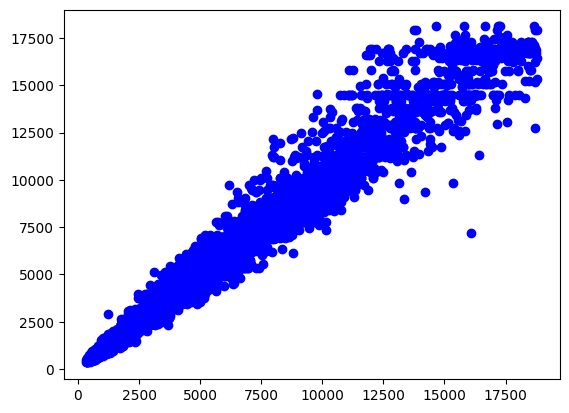

In [ ]:
# train test split with best parameters for plotting
best_regtree = DecisionTreeRegressor(max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf)
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.20)
best_regtree.fit(train_x, train_y)
pred_y = best_regtree.predict(test_x)
print(r2_score(test_y, pred_y))

# plotting actual prices against predicted prices
plt.scatter(test_y, pred_y, color='blue', label='Array 1')

**Regression Tree Analysis**

The Regression Tree model produced the overall best results out of any of the machine learning models we decided to implement. Initially it was performing poorly and overfitting the data, however, after using GridSearchCV to imitate the inner cross validation loop we were able to determine the best hyper-parameters to use for this model. Without limiting 'max_depth' and 'min_samples_leaf' we were letting the regression tree get too specific and allowing the validation error to increase after it hit its minimum. Moving past that we achieved an extremely high R2 score ranging around .96 - .97 after training the model with our newly found best parameters. The plot helps visualize this by plotting the predicted price against the actual price where its clear to see that the predicted price follows the actual quite closely.

## Regression Neural Net Model

We are using the MLP Regressor Model to predict price based on the other features. The nice thing about Neural Networks is that it will zero out any attributes which don't affect the price and minimize the effect of those which have some effect.

One problem with Neural Networks however is that they take a really long time, and with a data set of over 50,000 records the model does a lot more computations for not too much extra reward.

Thus for this model we split the data into train and test sets using an 80-20 split. We further sampled 40% of the data which we can use to determine a good set of parameters to base the model off.

In [ ]:
# Hussain
from sklearn.neural_network import MLPRegressor
data_x = df_reg.drop('price', axis=1)
data_y = df_reg['price']
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=21)
#Below used for searching best params since neural nets take so long
_, X_search, _, y_search = train_test_split(X_train, y_train, test_size=0.4, random_state=21)

In [ ]:
nn_scaler = StandardScaler()
mlp = MLPRegressor()
nn_pipeline = Pipeline([('scaler', nn_scaler), ('mlp', mlp)])

nn_param_grid = {
    'mlp__hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
    'mlp__activation': ['logistic', 'tanh', 'relu']
}

nn_grid_search = GridSearchCV(nn_pipeline, nn_param_grid, cv=5, scoring='r2')

nn_grid_search.fit(X_search, y_search)
print(nn_grid_search.best_params_)
print(nn_grid_search.best_score_)

{'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (60,)}
0.9230062839636013


After finding the best parameters, we use them to create a training model which we cross validate to determine how well it would perform. The cross validation score can't really be used as the final accuracy score because the data is somewhat polluted due to the grid search. It only gives us a rough estimate of what we can expect the model to be like.



In [ ]:
best_activation = nn_grid_search.best_params_['mlp__activation']
best_hidden_layers = nn_grid_search.best_params_['mlp__hidden_layer_sizes']
best_mlp = MLPRegressor(activation = best_activation, hidden_layer_sizes = best_hidden_layers)
best_nn_pipeline = Pipeline([('scaler', nn_scaler), ('mlp', best_mlp)])

nn_score = cross_val_score(best_nn_pipeline, X_train, y_train, cv=5, scoring='r2')
print("Neural Network training R2 Score:", nn_score.mean())

Neural Network training R2 Score: 0.9226816480860613


Since we have determined that the Neural Network Regressor model works pretty well, we can test it using the test set we set out earlier to determine how well this model truly works on unseen data. Ideally we would want to wrap the entire data set into a grid search which would run inside a cross validation loop, but due to the size of the data set and limited computing power, we chose to judge the model in this manner.

In [ ]:
test_mlp = MLPRegressor(activation = best_activation, hidden_layer_sizes = best_hidden_layers)
test_scaler = StandardScaler()
test_nn_pipeline = Pipeline([('scaler', test_scaler), ('mlp', test_mlp)])
test_nn_pipeline.fit(X_train, y_train)
y_pred = test_nn_pipeline.predict(X_test)
nn_regressor_r2 = r2_score(y_test, y_pred)
print("Final Neural Network r2 score:", nn_regressor_r2)

Final Neural Network r2 score: 0.9287232365647204


Overall, the Neural Network Regressor Model worked pretty well in predicting an approximate price based on the features given. This makes sense because we would expect there to be a pretty strong correlation between the features of the diamond and the price. Since Neural Nets update weights based on how much they affect the output, the weights of each feature are also adjusted accordingly.

#Classifier Neural Network Model

We use a Neural Network Classifier MLP model to determine cut based on the other features. Similar to the Regressor model, we split the data into training and test, and we split the training data to determine the best parameters.

In [ ]:
from sklearn.neural_network import MLPClassifier
data_class_x = df_reg.drop('cut', axis=1)
data_class_y = df_reg['cut']
X_train, X_test, y_train, y_test = train_test_split(data_class_x, data_class_y, test_size=0.2, random_state=21)
#Below used for searching best params since neural nets take so long
_, X_search, _, y_search = train_test_split(X_train, y_train, test_size=0.4, random_state=21)

In [ ]:
nn_scaler = StandardScaler()
mlp_class = MLPClassifier()
nn_class_pipeline = Pipeline([('scaler', nn_scaler), ('mlp', mlp_class)])
nn_class_param_grid = {
    'mlp__hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
    'mlp__activation': ['logistic', 'tanh', 'relu']
}

nn_class_grid_search = GridSearchCV(nn_class_pipeline, nn_class_param_grid, cv=5, scoring='accuracy')
nn_class_grid_search.fit(X_search, y_search)
print(nn_class_grid_search.best_params_)
print(nn_class_grid_search.best_score_)

{'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (60,)}
0.7440644499635491


In [ ]:
best_activation = nn_class_grid_search.best_params_['mlp__activation']
best_hidden_layers = nn_class_grid_search.best_params_['mlp__hidden_layer_sizes']
best_mlp = MLPClassifier(activation = best_activation, hidden_layer_sizes = best_hidden_layers)
best_nn_pipeline = Pipeline([('scaler', nn_scaler), ('mlp', best_mlp)])

nn_score = cross_val_score(best_nn_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Neural Network Trainning Accuracy:", nn_score.mean())

Neural Network Trainning Accuracy: 0.751446308529077


In [ ]:
test_mlp = MLPClassifier(activation = best_activation, hidden_layer_sizes = best_hidden_layers)
test_scaler = StandardScaler()
test_nn_pipeline = Pipeline([('scaler', test_scaler), ('mlp', test_mlp)])
test_nn_pipeline.fit(X_train, y_train)
y_pred = test_nn_pipeline.predict(X_test)
nn_classifier_accuracy = accuracy_score(y_test, y_pred)
print("Final Neural Network Accuracy:", nn_classifier_accuracy)

Final Neural Network Accuracy: 0.7489939637826962


The Neural Network Classifier model does a modest job in predicting the cut of the diamond based on the features. We expected the model to do better than 75%, but that wasn't the case. For this dataset, the Classifier model didn't make sense for too many features, and for those where it did make sense, it didn't work too well.

## Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist

sampled_data = df_reg.head(15000) # Google Colab crashes with records >= 15K
clustering_single = linkage(sampled_data, 'single')
clustering_complete = linkage(sampled_data, 'complete')
clustering_average = linkage(sampled_data, 'average')
clustering_centroid = linkage(sampled_data, 'centroid')
clustering_ward = linkage(sampled_data, 'ward')

proximity_matrix = pdist(sampled_data)

# Printing out the scores
cpcc_single = cophenet(clustering_single, proximity_matrix)
print("cpcc_single:", cpcc_single[0])
cpcc_complete = cophenet(clustering_complete, proximity_matrix)
print("cpcc_complete:", cpcc_complete[0])
cpcc_average = cophenet(clustering_average, proximity_matrix)
print("cpcc_average:", cpcc_average[0])
cpcc_centroid = cophenet(clustering_centroid, proximity_matrix)
print("cpcc_centroid:", cpcc_centroid[0])
cpcc_ward = cophenet(clustering_ward, proximity_matrix)
print("cpcc_ward:", cpcc_ward[0])

# Here we found the centroid method as the best linkage method

cpcc_single: 0.2692404088096612
cpcc_complete: 0.8367592112819313
cpcc_average: 0.8314450283653989
cpcc_centroid: 0.84741450195409
cpcc_ward: 0.8102283590505639


Plotting the dendrogram based on the best linkage method (centroid):

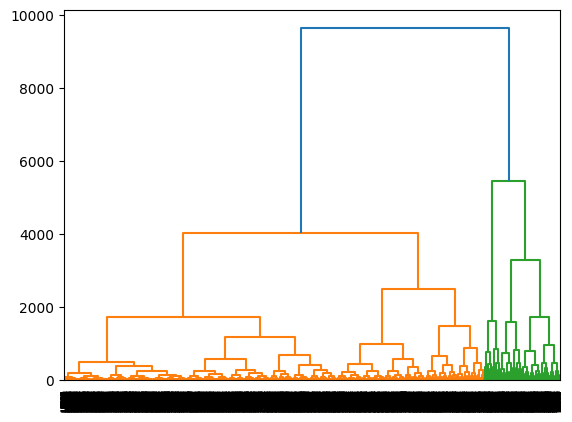

In [ ]:
from scipy.cluster.hierarchy import dendrogram

clustering_centroid = linkage(sampled_data, "centroid")
dendrogram = dendrogram(clustering_centroid)
plt.show()

Through the dendrogram shown below, we figured that we would cluster this into k=4 clusters since the vertical gap is relatively big before the next set of clusters are merged using the centroid method.

## Final Result (Conclusion)

We get the following R2 scores after running various supervised learning models:

- Linear Regression: 0.8309043457411013
- Multiple Regression: 0.8956912334841372 
- Regression Tree: 0.9734673658453226
- Neural Network: 0.9287232365647204


Through our supervised learning models we found that Regression Trees worked the best as they had the highest R2 score. Linear Regression came the last since increase in the price of the diamond does not grow linearly and flattens out a bit at the top due to various other features like 'cut'. 

For Unsupervised learning, we assessed the models based on cpcc to evaluate the accuracy. Through hierarchical clustering, we found that the data can be clustered into four groups based on 'price'.

Supervised Classifier Model:
- KNN: 0.6540492957746479
- Neural Network Classifier: 0.7481136820925554

Through this, the neural network classifier model worked best but in terms of accuracy niether model performed that well.

Overall, the diamonds dataset was easy to work with across all of our models (supervised vs unsupervised) and the resulting interpretation was concise with regards to features like 'carat', 'cut', 'clarity', and 'x/y/z-fractures' contributing towards the 'price' of the diamond.
